In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd

#Set an initial interest rate
initial_state = {'r': .08}


#Basic vasicek rate change model
def rate_change(r, a=.5, b=.06, sigma=.04, t=1/12):
    delta = a* (b-r) * t + t ** .5 * sigma * t ** .5 * norm.ppf(np.random.rand())
    return delta + r


#Policy for updating
def vasicek_policy(_params, substep, sH, s):
    r = rate_change(s['r'], _params['a'], _params['b'], _params['sigma'], _params['t'])
    return {'r': r}

#Simple state update
def update_rate(_params, substep, sH, s, _input):
    return ('r', _input['r'])

#Partial updates
PSUBs = [
    {
        "policies": {
            "rate_policy": vasicek_policy,
        },
        "variables": {
            "r": update_rate,
        }
    }
]

In [2]:
#Set simulation parameters
from cadCAD.configuration.utils import config_sim

#The M parameter will let us test different combinations of parameters
sim_config_dict = {
    'T': range(360),
    'N': 100,
"M": {'a': [.5,.25]*2, 'b':[.06], 'sigma':[.02]*2 + [.04]*2, 't':[1/12]}}

c = config_sim(sim_config_dict)


from cadCAD.configuration import Experiment

exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)

In [3]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)

from cadCAD import configs
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 4
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 4, 100, 1)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,

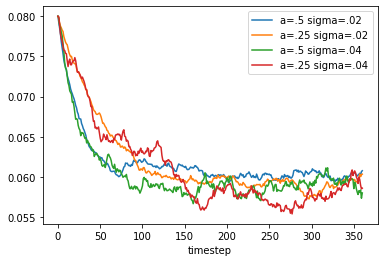

In [4]:
ts = result.groupby(['timestep', 'simulation'])['r'].mean().unstack()
ts.columns = ['a=.5 sigma=.02',
             'a=.25 sigma=.02',
             'a=.5 sigma=.04',
             'a=.25 sigma=.04']
ts.plot(kind='line')
plt.show()